## Introduction

This jupyter notebook is intended to introduce the numerical calculation of dynamic structure factor, namely the spectral function. As a concrete example, we consider the $S=1$ Heisenberg anti-ferromagnetic chain,

$$H = \sum_{j=1}^{L} (S^x_j S^x_{j+1} + S^y_j S^y_{j+1} + S^z_j S^z_{j+1}),$$

$L$ is the length of the chain and $S^{x,y,z}_j$ are spin operators defined on site $j$. Using the standard DMRG algorithm, we can easily get the ground state $|0\rangle$ and the corresponding energy $E_0$ of the system. For spin chains, the dynamic structure factor(DSF) is defined as,

$$S^{a}(k,\omega) \equiv \frac{1}{L} \sum_{x,y=1}^{L} e^{-ik(x-y)} \int_{-\infty}^{+\infty} \mathrm{d}t\, e^{i\omega t} \langle 0| S^{a}_x(t) S^{a}_{y}(0) |0 \rangle,$$

$a$ can be $x$(transversal DSF), $y$ or $z$(longitudinal DSF), and $S^{a}_{x}(t)$ are spin operators in the Heisenberg picture, namely $S^{a}_x(t) \equiv \exp{(iHt)}S^{a}_x\exp{(-iHt)}$. Exploiting the translational invariance(symmetry) of the system, the formula for DSF can be simplified as,

$$S^{a}(k,\omega) = \sum_{x=-L/2}^{L/2} e^{-ikx} \int_{-\infty}^{+\infty} \mathrm{d}t\, e^{i\omega t} \langle 0| S^{a}_x(t) S^{a}_{0} |0 \rangle,$$

here we have set the central site to be the "0" site. Since the DSF is just a double(space&time) Fourier Transformation of the time-dependent correlation function,

$$S^a(x,t) \equiv \langle 0| S^{a}_x(t) S^{a}_{0} |0 \rangle = e^{iE_0t} \langle 0| S^{a}_x e^{-iHt} S^{a}_0 |0 \rangle,$$

we can first use time evolution algorithms to evaluate $S^{a}(x,t)$ for all $x$ and $t$, and then apply a double FT to get the DSF.

## Data Set

In order to re-produce some results of the paper: *Spectral function for the S=1 Heisenberg antiferromagetic chain* by Steven R. White and Ian Affleck, PRB 77, 134437 (􏰉2008), we prepare two sets of time-dependent correlation function data:

- length-399_positive-time-22.dat, for $a=z, L=399$, maximum evoution time is 22 and $x=0$ only;
- length-399_positive-time-20.dat, for $a=z, L=399$, maximum evolution time is 20 and $x\in[0,198]$,

we use the first set of data to check the performance of Linear Prediction(Fig.4) which can be used to extend the evolution time and calculate the density of state(Fig.5): $N(w) = S^{z}(x=0,w)$, and the second set of data is used to calculate DSF with fixed $k$(Fig.7,13...).

Note: For open boundary conditions, the maximum evolution time for the second data set must be controlled(limited), such that the "information" created by applying $S^{z}_0$ on $|0\rangle$ has not propagated to the ends of the chain, so that the end effect does not "pollute" our results.

### Linear Prediction

The main code for Linear Prediction is included in file: *_module/linear_predicter.py*, and has been encapsulated as a class: *LinearPrediction*.

A detailed description of Linear Prediction algorithm can be found in Section 8.2 of [arXiv:1008.3477v2](arXiv:1008.3477v2).

*The code below should run very fast.*

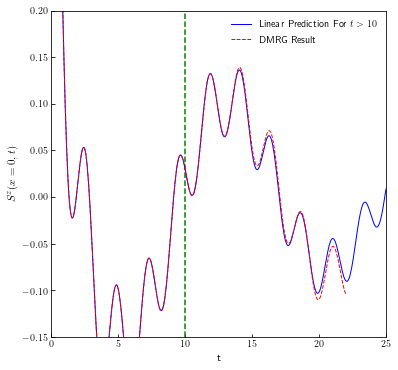

In [1]:
### import necessary modules
import json
import math
import numpy as np
from matplotlib import pyplot as plt
from _module.linear_predicter import LinearPrediction
%matplotlib inline


tstep = 0.05
tobs = 10. # the time used for linear prediction
fit_data = []
full_data = []

### get data from file
with open("length-399_positive-time-22.dat", 'r') as data_file:
    for lines in data_file.readlines():
        s = lines.strip().split('\t')
        s = list(map(float, s)) # list s: t, x=0, Real part, Imag part of S^z(x=0,t)
        re_data = [s[0], s[2]]
        full_data.append(re_data)
        if s[0] <= tobs + 1e-9:
            fdata = s[2] + s[3]*1.j
            fit_data.append(fdata)
              
### arguments for linear prediction
end = len(fit_data) - 1
start = int(end/2.)
order = int(end/3.)
cutoff = 1e-6
ext_num = int(end*1.5) # extend the time range upto 2.5*tobs

### linear prediction
model = LinearPrediction(order, start, end, cutoff)
extra_data = fit_data + model.extrapolate(fit_data, ext_num)

real_extra = []
for i in range(len(extra_data)):
    real_extra.append([tstep*i, extra_data[i].real])

real_full = np.array(full_data).T
real_extra = np.array(real_extra).T

### compare the results obtained by Linear Prediction with DMRG
plt.rc('text', usetex=True)
plt.figure(figsize=(6,6))
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.plot(real_extra[0], real_extra[1], c='b', label=r'Linear Prediction For $t > 10$', linewidth=1)
plt.plot(real_full[0], real_full[1], c='r', label='DMRG Result', linewidth=1, linestyle='dashed')
plt.vlines(10., -0.15, 0.2, colors = 'g', linestyles = "dashed")
plt.xlabel('t', fontsize=11)
plt.ylabel(r'$S^{z}(x=0,t)$', fontsize=11)
plt.legend(loc='best', frameon=False)
plt.xlim(0,25)
plt.ylim(-0.15,0.2)
fig4 = plt.gcf() # get current figure
fig4.savefig('Fig4.eps', format='eps', dpi=1000)

### Density of State
Here we try to calculate the density of state(DOS),
$$N(w) \equiv S^{z}(x=0,w) = \int_{-\infty}^{+\infty} \mathrm{d}t e^{i\omega t} S^{z}(x=0,t),$$
which is just a time-frequency FT of $S^{z}(x=0,t)$. However, there are some difficulties to apply such a transformation. Firstly, the time evolution algorithm we have in hand can only access a finite time domain(~10) for the rapidly increasing entanglement, thus we use linear prediction to extend the evolving time upto a desired value, at which $S^{z}(x=0,t)$ has converged to zero. Secondly, the time integration asks for positive and negative direction time evolutions which may cost a lot time. Here we utilize the "symmetry" between the positive and negative time to do the integration, so that only positive time evolution is needed. Note that,

$$S^{z}(x,t) = \langle 0| e^{iHt} S^{z}_x e^{-iHt} S^{z}_0 |0\rangle = \langle 0| S^{z}_x e^{-iHt} S^{z}_0 e^{iHt} |0\rangle = \langle 0| S^{z}_{-x} S^{z}_0(-t) |0\rangle = \langle 0| S^{z}_{0} S^{z}_x(-t) |0\rangle = S^{z}(x,-t)^*,$$

which is the result of time, space translational symmetry and inversion symmetry abount the "zero" site. We can thus use positve time data only to complete the time-frequency FT via the formula,

$$ e^{i\omega t} S^{z}(x,t) + e^{-i\omega t} S^{z}(x,-t) = e^{i\omega t} (Re + i*Im) + e^{-i\omega t} (Re - i*Im) = 2 [Re*\cos{(\omega t)} - Im*\sin{(\omega t)}],$$

$Re,Im$ are the real and imaginary parts of $S^{z}(x,t).$

*The code below may cost ~1min on laptop.*

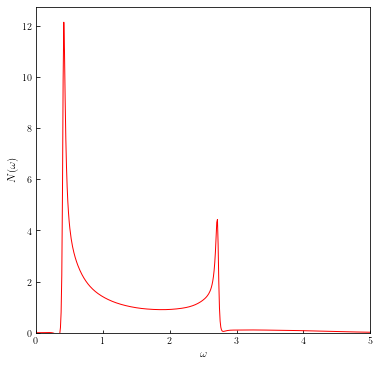

In [33]:
### import necessary modules
import json
import math
import numpy as np
from matplotlib import pyplot as plt
from _module.linear_predicter import LinearPrediction
%matplotlib inline

tobs = 20.
datas = []
with open("length-399_positive-time-22.dat", 'r') as data_file:
    for lines in data_file.readlines():
        s = lines.strip().split('\t')
        s = list(map(float, s))
        if s[0] <= tobs + 1e-9:
            data = s[2] + s[3]*1.j
            datas.append(data)

### arguments for linear prediction
tstep = 0.05
end = len(datas) - 1
start = int(end/2.)
order = int(end/4.)
cutoff = 1e-6
ext_num = int(end*20)

### linear prediction
model = LinearPrediction(order, start, end, cutoff)
datas = datas + model.extrapolate(datas, ext_num)

### format the data as: [time, correlation function]
t_cor = []
for i in range(len(datas)):
    t_cor.append([tstep*i, datas[i]])

### window function, ref: PRB77,134437(2008) or Section 8.2 of arXiv:1008.3477v2
tmax = t_cor[-1][0]
def window(t):
    return math.exp(-t**2/20./tmax**2)

### calculate density of states
ws = np.linspace(0.0, 5., 500)
density_state = []

for w in ws:
    S = 0.+0.j
    for ele in t_cor:
        if ele[0] <= 1e-9: # filter out the zero time point
            S += tstep * ele[1] * window(ele[0])
        else:
            S += tstep * 2. * ( math.cos(w*ele[0]) * ele[1].real - math.sin(w*ele[0]) * ele[1].imag ) * window(ele[0])
    density_state.append([w, S.real])

density_state = np.array(density_state).T

### plot the density of states v.s. frequency
plt.rc('text', usetex=True)
plt.figure(figsize=(6,6))
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.plot(density_state[0], density_state[1], c='r', linewidth=1)
plt.xlabel(r'$\omega$', fontsize=11)
plt.ylabel(r'$N(\omega)$', fontsize=11)
plt.xlim(0,5)
plt.ylim(0,)
fig5 = plt.gcf() # get current figure
fig5.savefig('Fig5.eps', format='eps', dpi=1000)

### Dynamic Structure Factor

In order to get the dynamic structure factor $S^{z}(k,\omega)$, we use the data set: length-399_positive-time-20.dat, and every element in the file is arranged as,

$$[t, x, Re, Im],$$

$Re, Im$ are the real and imaginary parts of $S^{z}(x,t).$

In [23]:
### import necessary modules
import json
import math
import numpy as np
from matplotlib import pyplot as plt
from _module.linear_predicter import LinearPrediction
%matplotlib inline

### parameters for data set
tstep = 0.01
k = math.pi / 10.
distance = 198 # max value of |l|
tolerance = 1e-6 # should be much smaller than tstep, and is used to filter 0.0 value

### get data from file
data = []
with open("length-399_positive-time-20.dat", 'r') as data_file:
    for lines in data_file.readlines():
        s = lines.strip().split('\t')
        s = [float(s[0]), int(s[1]), float(s[2]), float(s[3])] # convert strings to numbers
        data.append(s)
        
### put data into different categories according to values of distance/l
cat_data = []
for i in range(distance+1):
    cat_data.append([])

for ele in data: # in this way, the time order is preserved/contained
    for pos in range(distance+1):
        if ele[1] == pos:
            cat_data[pos].append(ele)
            continue

If we do first the time-frequency FT, we may(in some sense, must) encounter a divergent time extension, which is a disaster. Thus we exchange the order of FTs, namely space-momentum FT first and then time-frequency FT. In this order, we can get rid of the divergent problem and apply the linear prediction only once! We also move forward the window function ahead of the space-momentum FT to ensure the convergent beheaviour of the subsequent time extension. Thus we have to check that the amplitude of $S^{z}(k,t)$ decreases with the time, at least no divergent beheaviour is observed! Note that we only need the $x\geq0$ part of $S^{z}(x,t)$ to do the space-momentum FT for the inversion symmetry about "zero site", namely,
$$S^{z}(x,t) = S^{z}(-x,t).$$

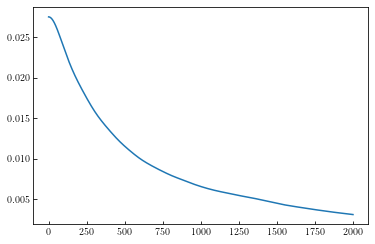

In [24]:
### fourier transformation for x -> k
length = len(cat_data[0])
k_data = []

### window function ahead of space-momentum FT
tmax = cat_data[0][-1][0]
def window(t):
    return math.exp(-t**2/20./tmax**2)

for i in range(length):
    S = 0.+0.j
    for categary in range(distance+1):
        temp = cat_data[categary][i]
        if categary == 0:
            S += temp[2]+temp[3]*1.j
        else:
            S += 2 * math.cos(k*categary) * (temp[2]+temp[3]*1.j)
    k_data.append(S) # in some cases, there is no need to apply the window function
#     k_data.append(S * window(tstep*i))
    
plt.plot(np.abs(np.array(k_data)))
plt.show()

After the space-momentum FT, we have $S^{z}(k,t)$ in hand now. Next we have to extend the evolving time upto a sufficiently large value and check that $S^{z}(k,t)$ is convergent to zero value.

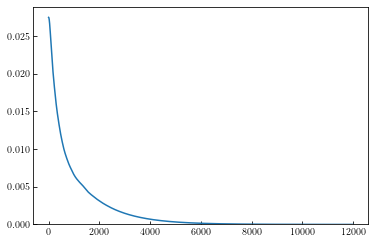

In [31]:
### linear prediction
end = len(k_data) - 1
start = int(end/2.)
order = int(end/50.)
cutoff = 1e-6
ext_num = int(end*5) # extend the time range

model = LinearPrediction(order, start, end, cutoff)
extra_data = k_data + model.extrapolate(k_data, ext_num)

tk_data = []
for i in range(len(extra_data)):
    tk_data.append([tstep*i, extra_data[i]])
    
plt.plot(np.abs(np.array(extra_data)))
plt.ylim(0,)
plt.show()

Finally, we do the time-frequency FT to get the dynamic structure factor $S^{z}(k,w)$. As the window function as been applied earlier, there is no window function any more.

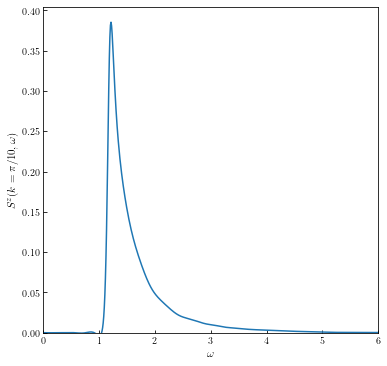

In [32]:
### fourier transformation for t -> w
ws = np.linspace(0., 6., 600)
Sw_data = []

for w in ws:
    S = 0.+0.j
    for ele in tk_data:
        if ele[0] <= tolerance:
            S += tstep * ele[1]
        else:
            S += tstep * 2. * ( math.cos(w*ele[0]) * ele[1].real - math.sin(w*ele[0]) * ele[1].imag )
    Sw_data.append([w, S.real])
    
Sw_data = np.array(Sw_data).T

### plot
plt.rc('text', usetex=True)
plt.figure(figsize=(6,6))
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.plot(np.array(Sw_data[0]), np.array(Sw_data[1]))
plt.xlabel(r'$\omega$', fontsize=11)
plt.ylabel(r'$S^{z}(k=\pi/10,\omega)$', fontsize=11)
plt.xlim(0.,6.)
plt.ylim(0,)
fig13 = plt.gcf() # get current figure
fig13.savefig('Fig13.eps', format='eps', dpi=1000)